In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset

In [2]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data 
y = (iris.target+1).astype(float)

val_idx = np.array(range(150))[::6] #every 6th to get 25
train_idx = np.array(list(set(range(150)) - set(val_idx))) #rest of it

train_primitive_matrix = X[train_idx,:]
val_primitive_matrix = X[val_idx,:]
train_ground = y[train_idx]
val_ground = y[val_idx]

## Synthesis + Verification
Generate functions based on feedback from the verifier (vary cardinality)

In [51]:
from program_synthesis.heuristic_generator import HeuristicGenerator
validation_accuracy = []
training_accuracy = []
validation_coverage = []
training_coverage = []

training_marginals = []
idx = None
weights = None

hg = HeuristicGenerator(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground, 
                            b=0.33)
for i in range(3,20):
    print i
    if i == 3:
        hg.run_synthesizer(max_cardinality=4, idx=None, weights=weights, keep=3, model='dt')
    else:
        hg.run_synthesizer(max_cardinality=4, idx=None, weights=weights, keep=1, model='dt')
    hg.run_verifier()
    
    va,ta, vc, tc = hg.evaluate()
    validation_accuracy.append(va)
    training_accuracy.append(ta)
    training_marginals.append(hg.vf.train_marginals)
    validation_coverage.append(vc)
    training_coverage.append(tc)
        
    hg.find_feedback()
    idx = hg.feedback_idx
    
    #For Rebuttal
    #weights = hg.vf.find_weighted_vague_points()
    
    if idx == []:
        break

3


In [52]:
from sklearn.metrics import f1_score

y_pred = np.argmax(training_marginals[-1],axis=-1)+1.
print "F1 score for Train Set: ", f1_score(train_ground, y_pred, average='micro')

F1 score for Train Set:  0.952


### Visualize Heuristic Behavior

ValueError: x and y must have same first dimension, but have shapes (17,) and (1,)

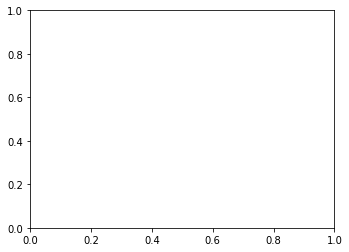

In [23]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(3,20),validation_accuracy, color='C0')
plt.plot(range(3,20),training_accuracy, color='C1')
plt.plot(range(3,20),validation_coverage, color='C0', linestyle='--')
plt.plot(range(3,20),training_coverage, color='C1', linestyle='--')
plt.legend(['Validation Set', 'Training Set'])
plt.xlabel('Number of Heuristics')
plt.ylabel('Accuracy and Coverage')
#plt.ylim([0.55,1.0])

plt.subplot(1,2,2)
bm = [(a*b) + (0.5*(1-b)) for a,b in zip(validation_accuracy,validation_coverage)] 
plt.plot(range(3,20),bm, color='C0')
bm = [(a*b) + (0.5*(1-b)) for a,b in zip(training_accuracy,training_coverage)] 
plt.plot(range(3,20),bm, color='C1')
plt.legend(['Validation Set', 'Training Set'])
plt.xlabel('Number of Heuristics')
plt.ylabel('Accuracy and Coverage')
#plt.ylim([0.55,1.0])
#plt.suptitle('Dataset: ' + dataset)

In [24]:
print "Program Synthesis Train Accuracy: ", np.max(training_accuracy[1:])
print "Program Synthesis Train Coverage: ", training_coverage[1:][np.argmax(training_accuracy[1:])]
print "Number of Heuristics: ", np.argmax(training_accuracy[1:])+4

print "Program Synthesis Validation Accuracy: ", np.max(validation_accuracy[3:])

Program Synthesis Train Accuracy: 

ValueError: zero-size array to reduction operation maximum which has no identity

In [25]:
# filepath = '/dfs/scratch0/paroma/reef/' + dataset
# old_reef = np.load(filepath+'_reef_nn2.npy')

# plt.hist(old_reef, bins=10, range=[0.0,1.0], alpha=0.75)
# plt.hist(training_marginals[1], bins=10, range=[0.0,1.0], alpha=0.75)
# plt.legend(['Subset', 'Weighted'])

### Save Reef Marginals

In [17]:
filepath = '/dfs/scratch0/paroma/reef/' + dataset
np.save(filepath+'_reef_pruner.npy', training_marginals[-1])

In [9]:
beta_opt = hg.syn.find_optimal_beta(hg.hf, hg.val_primitive_matrix, hg.feat_combos, hg.val_ground)
L_train_all = hg.apply_heuristics(hg.hf, primitive_matrix, hg.feat_combos, beta_opt)

from program_synthesis.verifier import Verifier
vf_temp = Verifier(L_train_all,L_train_all,train_ground, has_snorkel=False)
vf_temp.train_gen_model()
vf_temp.assign_marginals()
training_all = vf_temp.train_marginals

filepath = '/dfs/scratch0/paroma/reef/' + dataset
np.save(filepath+'_reef_pruner.npy', training_all)

## Calculate Baselines

In [11]:
from sklearn.metrics import f1_score

[**Decision Tree**](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
Depth bound is unbounded, using default settings. Could do a finer comparison if needed.

In [15]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0, min_samples_leaf=5, min_samples_split=10)
model.fit(val_primitive_matrix, val_ground)
y_pred = model.predict(train_primitive_matrix)
print "F1 score for Train Set: ", f1_score(train_ground, y_pred, average='micro')

F1 score for Train Set:  0.952


[**Boosting (AdaBoost)**](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) No bound of the number of estimators yet, could bound by number of primitives for "fair" comparison?

In [18]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(random_state=0)
model.fit(val_primitive_matrix, val_ground)
y_pred = model.predict(train_primitive_matrix)
print "F1 score for Train Set: ", f1_score(train_ground, y_pred, average='micro')

F1 score for Train Set:  0.952


[**LabelPropagation (Normal Semi-Supervised)**](http://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html#sklearn.semi_supervised.LabelSpreading)
Semi-supervised method that is robust to noise. Fits with both the labeled and unlabeled examples

In [24]:
from sklearn.semi_supervised import LabelSpreading

X_ss = np.concatenate((val_primitive_matrix, train_primitive_matrix))
val_labels = val_ground
train_labels = -1.*np.ones(np.shape(train_primitive_matrix)[0])
y_ss = np.concatenate((val_labels, train_labels))

model = LabelSpreading(kernel='knn', max_iter=100)
model.fit(X_ss, y_ss)
y_pred = model.predict(train_primitive_matrix)
print "F1 score for Train Set: ", f1_score(train_ground, y_pred, average='micro')

F1 score for Train Set:  0.968


### Save Baseline Marginals

In [14]:
# filepath = '/dfs/scratch0/paroma/reef/' + dataset

# np.save(filepath+'_dt_pruned.npy', dt.train_marginals)
# #np.save(filepath+'_bc.npy', bc.train_marginals)
# #np.save(filepath+'_ss.npy', ss.train_marginals)
# #np.save(filepath+'_css.npy', css.train_marginals)

# #np.save(filepath+'_gt.npy', train_ground)